In [1]:
import pandas as pd
d = pd.read_csv('data/Howell1.csv', sep = ';')
d.head(5)

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


## 4H1

Make a regression weight ~ height and calculate height and HPDI from this


$$h_i \thicksim Normal(\mu_i, \sigma)$$
$$\mu_i = \alpha + \beta * x_i$$
$$\alpha \thicksim Normal(178, 100)$$
$$\beta \thicksim Normal(0, 10)$$
$$\sigma \thicksim Normal(0, 50)$$

In [2]:
d2 = d[d['age']>= 18].copy()
d2.loc[:,'weight.s'] = d2['weight'] - d2['weight'].mean()
mean_w = d2['weight'].mean()

In [3]:
d_code = '''
data {
  int<lower=0> N;
  vector[N] height;
  vector[N] weight;
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}
model {
  alpha ~ normal(178,100);    
  beta ~ normal(0,10);
  sigma ~ cauchy(0,50);

  height ~ normal(alpha + beta * weight, sigma);
}
'''



In [4]:
d_dat = {}
d_dat['N'] = d2.shape[0]
d_dat['height'] = d2['height'].tolist()
d_dat['weight'] = d2['weight.s'].tolist()


In [6]:
#!pip install pystan

In [8]:
import pystan
sm = pystan.StanModel(model_code=d_code)
fit = sm.sampling(data=d_dat, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_705503ed40183f665d4ac61bfdeb4504 NOW.


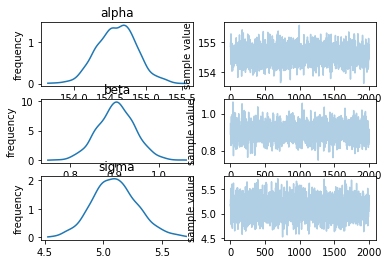

In [9]:
fit.plot()

In [10]:
par = fit.get_posterior_mean()[:,0]
a = par[0]
print (a)
b = par[1]
print(b)

154.609533795
0.904488921902


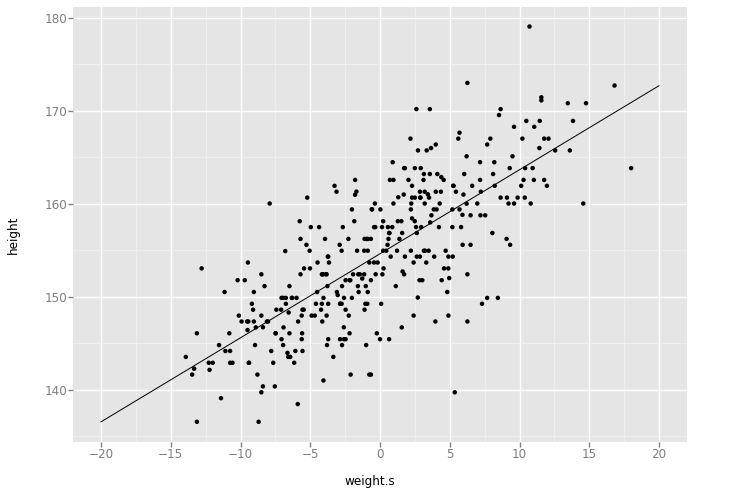

<ggplot: (-9223363299480480203)>

In [12]:
from ggplot import *
ggplot(d2, aes(x = 'weight.s', y = 'height')) + geom_point() + geom_abline(intercept = a , slope = b)

In [15]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_palette('colorblind'); sns.set_color_codes()

with pm.Model() as m4_3:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = alpha + beta * d2['weight.s']
    #mu = pm.Deterministic('mu', alpha + beta * d2.weight) # try uncomenting this line and comenting the above line
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_3 = pm.sample(2000)

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
 99%|█████████▉| 2483/2500 [00:02<00:00, 1108.38it/s]/opt/conda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.880032114883, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 2500/2500 [00:02<00:00, 1108.80it/s]


In [25]:
with m4_3:
    trace_4_3 = pm.sample(1000, init='advi_map')
    waic = pm.waic(trace_4_3)
    print ("WAIC: {}".format(waic))


INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using advi_map...
logp = -1,083.7, ||grad|| = 0.05975: 100%|██████████| 24/24 [00:00<00:00, 2342.59it/s]  
Average Loss = 1,096.2:   5%|▌         | 10033/200000 [00:04<01:27, 2173.38it/s]
INFO:pymc3.variational.inference:Convergence archived at 10200
INFO:pymc3.variational.inference:Interrupted at 10,199 [5%]: Average Loss = 1,187.7
100%|██████████| 1500/1500 [00:01<00:00, 982.73it/s]


WAIC: WAIC_r(WAIC=2148.087986883143, WAIC_se=29.832332890274301, p_WAIC=3.0714349078704322)


In [94]:
mu = alpha + beta * d2['weight.s']


beta

In [16]:
pm.df_summary(trace_4_3, alpha=0.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5
alpha,154.59,0.26,0.01,154.23,155.07
beta,0.90,0.04,0.00,0.83,0.97
sigma,5.11,0.20,0.00,4.79,5.42


In [26]:
pm.waic(trace_4_3)

TypeError: No context on context stack